# Berechnung von SpO$_2$ aus Photoplethysmogrammen
Visualisierung der Plethysmogramme für rotes und infrarotes Licht (z.B. bei $\lambda_R$=660 nm und $\lambda_{IR}$=905 nm.
 Das Verhältnis der relativen Transmissionsänderungen "Ratio of the ratios" $R$ wird aus den Plethysmogrammen berechnet gemäß: $$R=\frac{\frac{\Delta I_R}{I_R}}{\frac{\Delta I_{IR}}{I_{IR}}}=\frac{\Delta I_R \cdot I_{IR}}{\Delta I_{IR} \cdot I_{R}}$$
Der Zusammenhang zwischen $R$ und $SpO_2$ wird in einer empirischen Entsättigungsstudie mit freiwilligen Probanden ermittelt, in der diese ein sauerstoffreduziertes Gasgemisch atmen.  


Output()

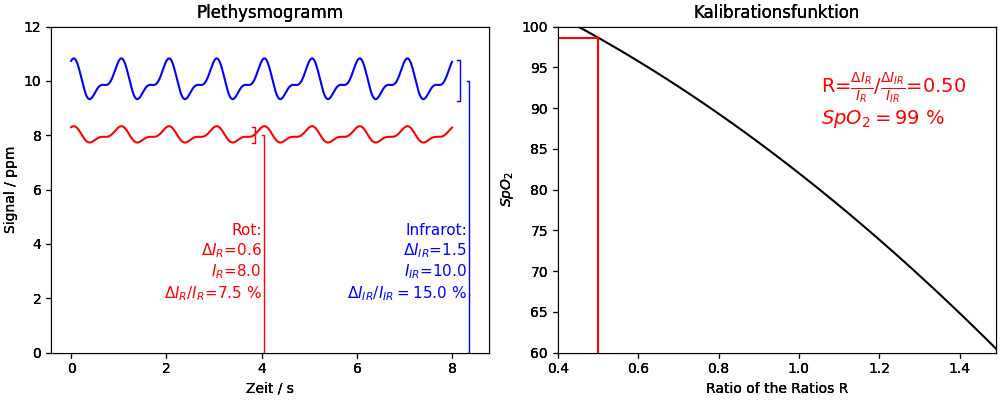

In [3]:
""" Demonstrator für den Zusammenhang zwischen Signalen und Sättigung

(c) Benno Dömer | HS Pforzheim
"""
import platform
if platform.system() == "Emscripten": # running in JupyterLite
    %pip install -r runtime-requirements.txt

%matplotlib widget

from numpy import (pi, log10, exp, sqrt, sin, cos, sinc, tan, angle, arange, 
                   real, imag, linspace, zeros, ones, mean)
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib.pyplot import (figure, plot, stem, legend,  
                               grid, xlabel, ylabel, subplot, title, clf, xlim, ylim)

# start values
ired_default = 8
iir_default = 10
pi_default = 15
pired_default = 7.5
spo2_default = 95

# 2nd order calibration polynome derived from 3 points: (sat,r)
s1 = (100,0.45)
s2 = (82,1)
s3 = (60,1.5)

m = np.array([[s1[1]**2, s1[1], 1],[s2[1]**2, s2[1], 1],[s3[1]**2, s3[1], 1]])
l = np.array([s1[0],s2[0],s3[0]])
a,b,c = np.linalg.solve(m,l)                     

#r_cur = - b/(2*a)+sqrt(b**2/(4*a**2)-(c-spo2_default)/a)
r_cur = pi_default/pi_default

r=arange(0.4,1.5,.01)
SpO2 = a* r**2 + b* r + c # calibration

fA = 100 #
tmax = 8
t = arange(0,tmax, 1/fA)

pleth = cos(2*pi*t)+0.5*cos(4*pi*t-pi/3) # simple pleth-like signal
pleth = pleth / (max(pleth)-min(pleth)) # adjust to 1 
pleth = pleth - mean(pleth)

fig, axs = plt.subplots(1,2,figsize=(10, 4), dpi=100, layout='constrained',num='Diagramme')

#pletr, = axs[0].plot(t,pi_default*r_cur/100*ired_default*pleth+ired_default,'r')
#pletir, = axs[0].plot(t,pi_default/100*iir_default*pleth+iir_default,'b')

pletr, = axs[0].plot(t,t,'r') # initial plot
pletir, = axs[0].plot(t,t,'b') # initial plot
t_ann=np.array([0, 0.05, 0.05, 0])
iann, = axs[0].plot(t_ann+tmax+.3,t_ann,'b',linewidth=1) # annotation i
diann, = axs[0].plot(t_ann+tmax+.1,t_ann,'b',linewidth=1) # annotation di
riann, = axs[0].plot(t_ann+tmax/2,t_ann,'r',linewidth=1) # annotation i
driann, = axs[0].plot(t_ann+tmax/2-.2,t_ann,'r',linewidth=1) # annotation di

axs[0].set_ylim(0,12)
axs[0].set_title('Plethysmogramm')
axs[0].set_xlabel('Zeit / s')
axs[0].set_ylabel('Signal / ppm')

irtxt=axs[0].text(tmax+.3,2,'',color='b',fontsize=11,ha='right') # txt for IR 
redtxt=axs[0].text(tmax/2,2,'',color='r',fontsize=11,ha='right') # txt for Red

axs[1].plot(r,SpO2,'k')
axs[1].set_xlim(min(r),max(r))
axs[1].set_ylim(60,100)
axs[1].set_title('Kalibrationsfunktion')
axs[1].set_xlabel('Ratio of the Ratios R')
axs[1].set_ylabel('$SpO_2$')

spo2txt=axs[1].text(0.6, 0.7,'',transform=axs[1].transAxes,color='red', fontsize=14) # txt for R and SpO2

cur, = axs[1].plot(np.array([0.4,r_cur, r_cur]),np.array([spo2_default,spo2_default,0]),'r') # marker for currrent SpO2

def updateSigs(ired,pired,i,pi):
    r_cur = (pired)/(pi) #- b/(2*a)+sqrt(b**2/(4*a**2)-(c-spo2)/a)
    cur.set_xdata(np.array([0.4,r_cur, r_cur]))
    spo2 = a* r_cur**2 + b* r_cur + c
    cur.set_ydata(np.array([spo2,spo2,0]))
    
    dii = i*pi/100
    dired = ired*pired/100
    irtxt.set_text('Infrarot:\n'+r'$\Delta I_{IR}$'+f'={dii:.1f}\n'+r'$I_{IR}$'+f'={i:.1f}\n' 
                   +r'$\Delta I_{IR}/I_{IR}=$'+f'{pi:.1f} %')
    redtxt.set_text('Rot:\n'+r'$\Delta I_{R}$='+f'{dired:.1f}\n'+'$I_{R}$='+f'{ired:.1f}\n'
                   +r'$\Delta I_{R} / I_{R}$='+f'{pired:.1f} %')
    #irtxt.set_text('Infrared:\n'+r'$I_{IR}$'+f'={i:.1f}'+r', $\Delta I_{IR}$'+f'={i*pi/100:.1f}\n'
    #               +r'$\Delta I_{IR}/I_{IR}=$'+f'{i*pi/100/i*100:.1f} %')
    #redtxt.set_text('Red:\n$I_{Red}$='+f'{ired:.1f}'+r', $\Delta I_{Red}$='+f'{ired*r_cur*pi/100:.1f}\n'
    #               +r'$\Delta I_{Red} / I_{Red}$='+f'{ired*pi*r_cur/100/ired*100:.1f} %')
        
    pletir.set_ydata((pi/100*i)*pleth+i)
    pletr.set_ydata(pired/100*ired*pleth+ired)
    iann.set_ydata(np.array([0,0,i,i])) 
    diann.set_ydata(np.array([i-dii/2,i-dii/2,i+dii/2,i+dii/2])) 
    riann.set_ydata(np.array([0,0,ired,ired])) 
    driann.set_ydata(np.array([ired-dired/2,ired-dired/2,ired+dired/2,ired+dired/2])) 
    
#    spo2txt.set_text(r'R=$\frac{\frac{\Delta I_R}{I_R}}{\frac{\Delta I_{IR}}{I_{IR}}}$'
#                     +f'={r_cur:.2f}\n'+r'$SpO_2=$'+f'{spo2:.0f} %')
    spo2txt.set_text(r'R=$\frac{\Delta I_R}{I_R} / \frac{\Delta I_{IR}}{I_{IR}}$'
                     +f'={r_cur:.2f}\n'+r'$SpO_2=$'+f'{spo2:.0f} %')

    fig.canvas.draw()


iredslider  = widgets.FloatSlider(min=1, max=10, step=1, value=ired_default, continuous_update=True, description='$I_{R}$')
piredslider = widgets.FloatSlider(min=1, max=20, step=0.5, value=pired_default, continuous_update=True, description=r'$\Delta I_R/I_R$/%')
islider  = widgets.FloatSlider(min=1, max=10, step=1, value=iir_default, continuous_update=True, description='$I_{IR}$')
pislider  = widgets.FloatSlider(min=1, max=20, step=0.5, value=pi_default, continuous_update=True, description=r'$\Delta I_{IR}/I_{IR}$/%')
ui1 = widgets.HBox([widgets.Label(value='Rot'), iredslider, piredslider],border='solid 2px red',)
ui2 = widgets.HBox([widgets.Label(value='Infrarot'), islider, pislider],border='solid 2px blue',)
ui1.layout = widgets.Layout( border='solid 2px red')
ui2.layout = widgets.Layout( border='solid 2px blue')
out = widgets.interactive_output(updateSigs, { 'ired': iredslider,'pired': piredslider,'i': islider, 'pi': pislider}) #(ired,pired,i,pi)
display(ui2,ui1, out)
plt.show()
